# Reinforcement Learning
Prof. Milica Gašić

### Linear value function approximation

In this notebook, we will implement semi-gradient TD(0) with linear value function approximation.
This means that we will represent the value function by a linear combination of features:
$$
\hat{v}(s,w) = x(s)^\top w = \sum_{j=1}^d x(s)_j \, w_j
$$
where $s$ is a state, $x(s) \in \mathbb{R}^d$ is a feature vector of the state, and $w \in \mathbb{R}^d$ is a weight vector.  

The update rule for semi-gradient TD(0) prediction is given by
$$
w \leftarrow w + \alpha (\underbrace{r_{t+1} + \gamma \hat{v}(s_{t+1}, w) - \hat{v}(s_t, w)}_{\text{TD error}}) \nabla_w \hat{v}(s_t, w)
$$
where $\alpha > 0$ is the learning rate and $\nabla_w \hat{v}(s_t, w)$ is the gradient of the value function with respect to the weight vector.  
For a linear value function the gradient is equal to $\nabla_w \hat{v}(s_t, w) = x(s)$.

### Implementation

Make sure that the files `rl_env.py` and `rl_tests.py` are in the same folder as the notebook.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

import rl_env
import rl_tests

#### Features

We will work with tabular environments with state space $\mathcal{S} = \{0, 1, \ldots, N\}$,  
where we assume $0$ to be the terminal state and $N$ is the number of non-terminal states.

To apply linear value function approximation, we need a way to convert an integer state $s \in \mathcal{S}$ into a real-valued feature vector $x(s) \in \mathbb{R}^d$.  
Since the value of terminal states is always zero, we don't need a feature vector for terminal state $s = 0$.  
We will consider three types of feature vectors:

**1. One-hot features** (aka table lookup features): $x(s) = \begin{bmatrix} [s = 1], [s = 2], \ldots, [s = N] \end{bmatrix}^\top$.  
In other words, $x(s)$ is an $N$-dimensional vector with a 1 for state $s$ and 0s everywhere else.

**2. State aggregation features**: $x(s) = \begin{bmatrix} [1 \le s \le k], [k + 1 \le s \le 2k], \ldots, [N-k+1 \le s \le N] \end{bmatrix}^\top$.  
In other words, we aggregate states into groups and create a one-hot vector. The size of each group is $k$.

**3. State normalization features**: $x(s) = \begin{bmatrix} (s - 1) / (N - 1) - 0.5 \end{bmatrix}^\top$.  
In other words, we convert the integer into a real value between $-0.5$ and $0.5$ and create a 1-dimensional vector.

Implement the three types of features as described above.  

Note that `__call__()` is a special Python method that allows us to treat objects of a class as functions, e.g.,  
```
   feature_fn = OneHotFeatures(env)
   x = feature_fn(s)
```

In [2]:
class OneHotFeatures:

    def __init__(self, observation_space):
        if not isinstance(observation_space, gym.spaces.Discrete):
            raise ValueError('Observation space must be discrete')

        # number of non-terminal states
        self.num_states = observation_space.n - 1

    def __call__(self, state):
        #######################################################################
        # TODO Create a numpy array that contains the one-hot features for a  #
        # non-terminal state. The size of the array should be self.num_states #
        # Remember that state 0 is a terminal state, so you need to shift the #
        # state by -1 to get the correct index in the array.                  #
        #######################################################################

        x = np.zeros(self.num_states)
        x[state - 1] = 1

        #######################################################################
        # End of your code.                                                   #
        #######################################################################
        return x.astype(np.float32, copy=False)


class StateAggregationFeatures:

    def __init__(self, observation_space, group_size):
        # state 0 is assumed to be the terminal state

        if not isinstance(observation_space, gym.spaces.Discrete):
            raise ValueError('Observation space must be discrete')
        if (observation_space.n - 1) % group_size != 0:
            raise ValueError('Number of non-terminal states must be divisible by group_size')

        self.group_size = group_size

        # number of non-terminal states
        num_states = observation_space.n - 1
        self.num_groups = num_states // group_size

    def __call__(self, state):
        #######################################################################
        # TODO Create a numpy array that contains the state aggregation       #
        # features for a non-terminal state. The size of the array should be  #
        # self.num_groups. Remember that state 0 is a terminal state, so you  #
        # need to shift the state by -1 to get the correct index.             #
        #######################################################################

        x = np.zeros(self.num_groups)
        x[(state - 1) // self.group_size] = 1

        #######################################################################
        # End of your code.                                                   #
        #######################################################################
        return x.astype(np.float32, copy=False)


class StateNormalizationFeatures:

    def __init__(self, observation_space):
        if not isinstance(observation_space, gym.spaces.Discrete):
            raise ValueError('Observation space must be discrete')

        # number of non-terminal states
        self.num_states = observation_space.n - 1

    def __call__(self, state):
        #######################################################################
        # TODO Create a numpy array that contains the state normalization     #
        # feature for a non-terminal state, as described above. The size of   #
        # the array should be 1.                                              #
        #######################################################################
        x = np.array([(state - 1) / (self.num_states - 1) - .5])
        #######################################################################
        # End of your code.                                                   #
        #######################################################################
        return x.astype(np.float32, copy=False)

You can use the following code cell to test your implementation.  
**Important**: After changing your code, execute the above code cell before running the tests.

In [3]:
def test_features():
    yield 'OneHotFeatures'

    obs_space = gym.spaces.Discrete(5)
    features = OneHotFeatures(obs_space)
    x = features(3)
    if (yield from rl_tests.check_numpy_array(x, 'Feature vector', shape=(features.num_states,), dtype=np.float32)):
        yield np.array_equal(x, np.array([0.0, 0.0, 1.0, 0.0])), 'The feature vector is incorrect'
    yield None

    obs_space = gym.spaces.Discrete(12)
    features = OneHotFeatures(obs_space)
    x = features(6)
    if (yield from rl_tests.check_numpy_array(x, 'Feature vector', shape=(features.num_states,), dtype=np.float32)):
        yield np.array_equal(x, np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0])), 'The feature vector is incorrect'
    yield None

    yield 'StateAggregationFeatures'

    obs_space = gym.spaces.Discrete(26)
    features = StateAggregationFeatures(obs_space, group_size=5)
    x = features(20)
    if (yield from rl_tests.check_numpy_array(x, 'Feature vector', shape=(features.num_groups,), dtype=np.float32)):
        yield np.array_equal(x, np.array([0.0, 0.0, 0.0, 1.0, 0.0])), 'The feature vector is incorrect'
    yield None

    x = features(21)
    if (yield from rl_tests.check_numpy_array(x, 'Feature vector', shape=(features.num_groups,), dtype=np.float32)):
        yield np.array_equal(x, np.array([0.0, 0.0, 0.0, 0.0, 1.0])), 'The feature vector is incorrect'
    yield None

    obs_space = gym.spaces.Discrete(101)
    features = StateAggregationFeatures(obs_space, group_size=10)
    x = features(85)
    if (yield from rl_tests.check_numpy_array(x, 'Feature vector', shape=(features.num_groups,), dtype=np.float32)):
        yield np.array_equal(x, np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0])), 'The feature vector is incorrect'
    yield None

    yield 'StateNormalizationFeatures'

    obs_space = gym.spaces.Discrete(26)
    features = StateNormalizationFeatures(obs_space)
    for s, expected in zip([1, 5, 20, 25], [-0.5, -0.33333334, 0.29166666, 0.5]):
        x = features(s)
        if (yield from rl_tests.check_numpy_array(x, 'Feature vector', shape=(1,), dtype=np.float32)):
            yield np.allclose(x, np.array([expected])), f'The feature vector is incorrect (error = {abs(x[0] - expected):.5f})'
        yield None

    obs_space = gym.spaces.Discrete(131)
    features = StateNormalizationFeatures(obs_space)
    for s, expected in zip([71, 102], [0.04263566, 0.28294572]):
        x = features(s)
        if (yield from rl_tests.check_numpy_array(x, 'Feature vector', shape=(1,), dtype=np.float32)):
            yield np.allclose(x, np.array([expected])), f'The feature vector is incorrect (error = {abs(x[0] - expected):.5f})'
        yield None


rl_tests.run_tests(test_features())

Testing OneHotFeatures...
2/2 tests passed!

Testing StateAggregationFeatures...
3/3 tests passed!

Testing StateNormalizationFeatures...
6/6 tests passed!


#### Value functions

We will use the following base class for state value functions:

In [4]:
class ValueFunction:

    def reset(self):
        # reset the value function, e.g. reset the weight vector
        raise NotImplementedError()

    def evaluate(self, state):
        # compute the value of a state
        raise NotImplementedError()

    def update(self, state, target):
        # update the value of a state toward a given target
        raise NotImplementedError()

The following class implements linear value functions, supports TD(0), and stores its weight vector.
The learning rate `alpha` is also part of the value function and it will be used in the `update()` method.  
The parameter `feature_fn` is a function that computes a feature vector for a given state.

In [5]:
class LinearValueFunction(ValueFunction):

    def __init__(self, observation_space, alpha, gamma, lmbda, feature_fn):
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.lmbda = lmbda  # value for TD(lambda)

        # function that converts a state into a feature vector
        self.feature_fn = feature_fn

        # determine the size of the feature vectors
        # sample a random state and convert it to a feature vector
        sample_features = feature_fn(observation_space.sample())
        if not (isinstance(sample_features, np.ndarray) and len(sample_features.shape) == 1):
            raise ValueError('Features must be real-valued vectors')

        # size of feature vectors (= d)
        self.feature_dim = sample_features.shape[0]

        self.reset()

    def reset(self):
        # create weight vector with size of feature vectors, initialize with zeros
        self.weights = np.zeros(self.feature_dim, dtype=np.float32)

        # create eligibility vector (only when necessary)
        if self.lmbda == 0:
            # not needed for TD(0)
            self.eligibility = None
        else:
            # initialize with zeros
            self.eligibility = np.zeros(self.feature_dim, dtype=np.float32)

    def evaluate(self, state):
        w = self.weights  # weight vector
        #######################################################################
        # TODO Evaluate a state by computing the dot product between the      #
        # features and the weight vector, as described above.                 #
        # Use self.feature_fn to compute the feature vector.                  #
        #######################################################################

        x = self.feature_fn(state)
        v = x.T @ w

        #######################################################################
        # End of your code.                                                   #
        #######################################################################
        return v

    def update(self, state, target):
        w = self.weights  # weight vector
        e = self.eligibility  # eligibility vector
        alpha = self.alpha  # learning rate
        gamma = self.gamma  # discount factor
        lmbda = self.lmbda  # value for TD(lambda)
        #######################################################################
        # TODO Update the weight vector using the update rule                 #
        # described above. The parameter `target` contains the TD target, so  #
        # it does not need to be computed here, only the TD error.            #
        #######################################################################

        w += alpha * (target - self.evaluate(state)) * self.feature_fn(state)

        #######################################################################
        # End of your code.                                                   #
        #######################################################################
        self.weights = w

You can use the following code cell to test your implementation.  
**Important**: After changing your code, execute the above code cell before running the tests.

In [6]:
def test_linear_value_function():
    yield 'evaluate()'

    obs_space = gym.spaces.Discrete(10)
    feature_fn = lambda s: np.array([float(s), float(s) * 2, float(s) * 3])

    vf = LinearValueFunction(obs_space, alpha=0.1, gamma=0.9, lmbda=0.0, feature_fn=feature_fn)
    vf.weights = np.array([-0.5, 0.4, 0.3])
    for s, expected in zip([1, 2, 5, 10], [1.2, 2.4, 6.0, 12.0]):
        v = vf.evaluate(s)
        yield np.isclose(v, expected), f'The computed value is incorrect (error = {abs(v - expected):.5f})'
        yield None

    yield 'update() with lmbda == 0'

    vf = LinearValueFunction(obs_space, alpha=0.1, gamma=0.9, lmbda=0.0, feature_fn=feature_fn)
    for s, target, expected_w in [(1, 0.4, np.array([0.04, 0.08, 0.12])), (4, 0.65, np.array([-0.59599996, -1.1919999, -1.788]))]:
        vf.update(s, target)
        yield np.allclose(vf.weights,
                          expected_w), f'The updated weights are incorrect (error = {np.sum(np.abs(vf.weights - expected_w)):.5f})'
        yield None

    yield None


rl_tests.run_tests(test_linear_value_function())

Testing evaluate()...
4/4 tests passed!

Testing update() with lmbda == 0...
3/3 tests passed!


### Evaluation

We will evaluate the algorithms on the 1000-state random walk environment from the lecture.  
To compare the estimated values to the true values, we load them from the file `random-walk-1000.npy`:

In [7]:
true_values = np.load('random-walk-1000.npy')

Now we evaluate TD(0) and TD($\lambda$) using the three types of features.  
We plot the estimated values for all states after 100, 500, and 5000 episodes.  
What do you observe?

Episode 100


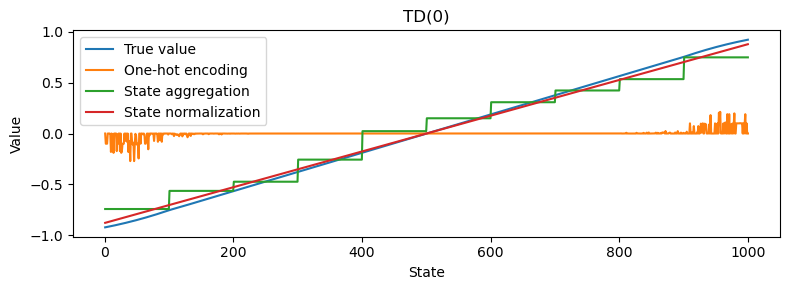

Episode 500


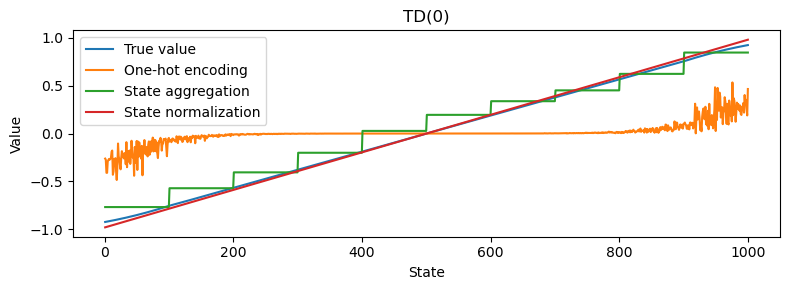

Episode 5000


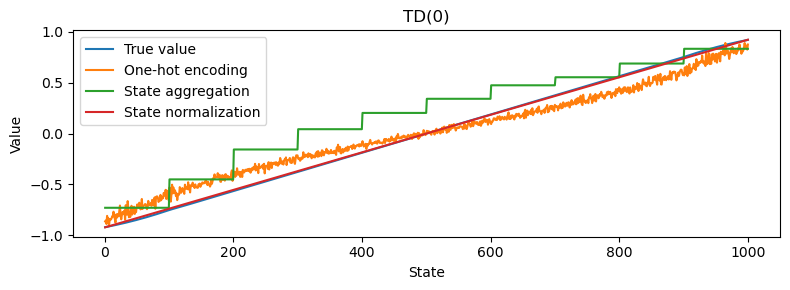

In [8]:
# create an instance of the environment
env = rl_env.RandomWalk1000Env()

gamma = 1.0  # discount factor
lmbda = 0.9  # value for TD(lambda)
alpha = 0.1  # learning rate

# evaluate the value functions after these episodes
milestones = [100, 500, 5000]
num_episodes = milestones[-1]

# create feature functions
observation_space = env.observation_space
one_hot_features = OneHotFeatures(observation_space)
aggregation_features = StateAggregationFeatures(observation_space, group_size=100)
normalization_features = StateNormalizationFeatures(observation_space)

# create linear value functions for TD(0)
one_hot_vf = LinearValueFunction(observation_space, alpha, gamma, 0, one_hot_features)
aggregation_vf = LinearValueFunction(observation_space, alpha, gamma, 0, aggregation_features)
normalization_vf = LinearValueFunction(observation_space, alpha, gamma, 0, normalization_features)

td_0_vfs = [one_hot_vf, aggregation_vf, normalization_vf]
labels = ['One-hot encoding', 'State aggregation', 'State normalization']

for episode in range(num_episodes):
    state, _ = env.reset()
    while True:
        action = 0  # Markov reward process, one action with no meaning
        next_state, reward, terminated, truncated, _ = env.step(action)

        # update all value functions
        for vf in td_0_vfs:
            # compute the TD target
            if terminated:
                target = reward
            else:
                target = reward + gamma * vf.evaluate(next_state)
            # update the value function
            vf.update(state, target)

        if terminated or truncated:
            break

        state = next_state

    if (episode + 1) in milestones:
        # compute and plot the values for all states

        print(f'Episode {episode + 1}')

        fig, axes = plt.subplots(1, 1, figsize=(8, 3), sharex=True, sharey=True)
        axes.set_title('TD(0)')
        axes.set_xlabel('State')
        axes.set_ylabel('Value')

        num_states = env.observation_space.n
        states = np.arange(1, num_states)
        axes.plot(states, true_values, label='True value')

        for vf, label in zip(td_0_vfs, labels):
            values = np.zeros(num_states)
            for state in range(num_states):
                values[state] = vf.evaluate(state)
            axes.plot(states, values[1:], label=label)

        axes.legend()
        fig.tight_layout()
        plt.show()